# 1D

### Define problem, initial and boundary conditions

In [1]:

import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt

n_dim = 1

#Define global variables
r = 0.01
T = 3
K = 10
sigma = 0.05
DTYPE = 'float32'

#Fix seeds
random_seed = 2
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


F:\anaconda3\envs\PINN\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:

class Sampler_IBC():
    def __init__(self, lb, ub, cond=None, N_points=100,
                 method='uniform', grid=None, split=False, DTYPE='float64'):
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        self.sample(N_points, method, grid, split)

    def sample(self, N_points, method, grid, split):
        if method == 'uniform':
            x_ibc = np.random.uniform(0, 1, size=(N_points, self.ub.shape[0]))
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'latin':
            from pyDOE import lhs
            x_ibc = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0],N_points)
        elif method == 'sobol':
            import sobol
            x_ibc = sobol.sample(dimension=self.ub.shape[0], n_points=N_points)
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'equi':
            x_ibc = np.linspace(self.lb, self.ub, N_points)
        elif method == 'grid':
            x_ibc = np.linspace(self.lb, self.ub, N_points).T
            temp_final = list()
            for val in x_ibc[0]:
                temp_final.append( [val] )
            dim = 1
            while dim < x_ibc.shape[0]:
                temp = list()
                for t1 in range(x_ibc.shape[1]):
                    for t2 in range(len(temp_final)):
                        temp_val = temp_final[t2].copy()
                        temp_val.append( x_ibc[dim, t1] )
                        temp.append( temp_val )
                temp_final = temp
                dim += 1
            x_ibc = np.array(temp_final)
        elif method == 'grid_old':
            idx = np.random.choice(range(grid.shape[0]),N_points,replace=False)
            x_ibc = grid[idx]
        if self.cond != None:
            y_ibc = self.cond(x_ibc)
            self.y = tf.cast(tf.Variable(y_ibc, trainable=False ),
                             self.DTYPE)
        if split:
            x_ibc, t_ibc = x_ibc[:, :-1], x_ibc[:, -1:]
            self.t = tf.cast(tf.Variable(t_ibc, trainable=False ),
                             self.DTYPE)
        self.x = tf.cast(tf.Variable(x_ibc, trainable=False ),
                         self.DTYPE)


In [3]:

#Define domain boundaries
lb = np.array([0., 0.])
ub = np.array([3.*K, T])

#Define conditions
def h_1(inp):
    res = list()
    for inp_val in inp:
        res.append( K - inp_val[0] )
    return np.array(res)

def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = np.zeros( inp.shape[0] )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        x, t = inp_val
        res.append( np.max([0, K-x]) )
    return np.array(res)

def s_0(inp):
    res = np.ones( inp.shape[0] ) * K
    return np.array(res)

#Point sampling
N_to_sample = 300

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = Sampler_IBC(np.array([0., T]),
                           np.array([3.*K, T]),
                           u_0, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
dir_sampler = Sampler_IBC(np.array([3.*K, 0.]), np.array([3.*K, T]),
                          g, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             h_2, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f't: {neu_fb_sampler.x.shape}     y: {neu_fb_sampler.y.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


PDE COnditions

x: (300, 2)     y: (300,)
x: (300, 2)     y: (300,)
No

Free Boundary COnditions

t: (1, 1)     y: (1,)
t: (300, 1)
t: (300, 1)     y: (300,)


In [4]:

test_sampler = Sampler_IBC(lb, ub, cond=None, DTYPE=DTYPE,
                           N_points=1000000, method='uniform', split=True)

#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler_test = Sampler_IBC(np.array([0., T]),
                           np.array([3.*K, T]),
                           u_0, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {init_sampler_test.x.shape}     y: {init_sampler_test.y.shape}' )

#Dirichlet
dir_sampler_test = Sampler_IBC(np.array([3.*K, 0.]), np.array([3.*K, T]),
                          g, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {dir_sampler_test.x.shape}     y: {dir_sampler_test.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler_test = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE, method='uniform' )
print( f't: {init_fb_sampler_test.x.shape}     y: {init_fb_sampler_test.y.shape}' )

#Dirichlet
dir_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {dir_fb_sampler_test.x.shape}' )

#Neumann
neu_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                             h_2, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {neu_fb_sampler_test.x.shape}     y: {neu_fb_sampler_test.y.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':init_sampler_test,
                   'Dirichlet':dir_sampler_test,
                   'Neumann':None}
fb_cond_test = {'Initial':init_fb_sampler_test,
                 'Dirichlet':dir_fb_sampler_test,
                 'Neumann':neu_fb_sampler_test}


PDE COnditions

x: (1000, 2)     y: (1000,)
x: (1000, 2)     y: (1000,)
No

Free Boundary COnditions

t: (1, 1)     y: (1,)
t: (1000, 1)
t: (1000, 1)     y: (1000,)


### PINN

In [5]:

#Define PDE
def pde(tape, xs, ts, u_val, u_x):
    u_xx = tape.gradient(u_x, xs)
    u_t = tape.gradient(u_val, ts)
    del(tape)
    u_val = tf.cast(u_val, DTYPE)
    f = (r * xs * u_x) + u_t + (sigma**2 * xs**2 * u_xx)/2 - (r * u_val)
    return f


In [6]:

import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

class FreeBoundary_PINN():

    def __init__(self, params, pde, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define pde
        self.pde = pde
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-1], trainable=False),
                                 self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -1:], trainable=False),
                                 self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                    )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values
                            ) * K - s_values
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * K - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * K - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-test_ibc_fb_cond['Initial'].y)
                )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values
                    ) * K - s_values
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=False)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-test_ibc_fb_cond['Neumann'].y)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t], axis=-1),
                               training=False)
        x_f = tf.reshape(test_sampler.x[ test_sampler.x > s_values ],
                          (-1,1) )
        t_f = tf.reshape(test_sampler.t[ test_sampler.x > s_values ],
                          (-1,1) )
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            pinn_tape.watch(x_f)
            pinn_tape.watch(t_f)
            #Apply u function for unsupervised
            u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                            training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
        unsup_loss = tf.reduce_mean(tf.square(
            self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims( test_ibc_cond['Initial'].y, axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=False)
            dir_loss = tf.math.reduce_mean(
                tf.math.square(pinn_dc-test_ibc_cond['Dirichlet'].y)
                )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l


### Example

PINNs - Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch     Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          


1         0.01692835     2.67740988     0.95791256     0.00000000     102.306488     3.33111405     0.76398760     106.401588     7.74735260     
51        0.00442334     0.10389396     0.00002416     0.00000000     0.02983020     0.16618162     0.33213260     0.52814441     0.60665571     
101       0.00613720     0.12300665     0.00484644     0.00000000     0.02166632     0.11264912     0.23359461     0.36791008     0.48023405     
151       0.00188866     0.02387251     0.00011912     0.00000000     0.01914587     0.00116613     0.03828868     0.05860069     0.06533512     
201       0.00289981     0.01978931     0.00220610     0.00000000     0.01093396     0.04973088     0.01037164     0.07103650     0.08499776     
251       0.00357198     0.03413606     0.00014337     0.00000000     0.00011654     0.05032217     0.00982331     0.06026

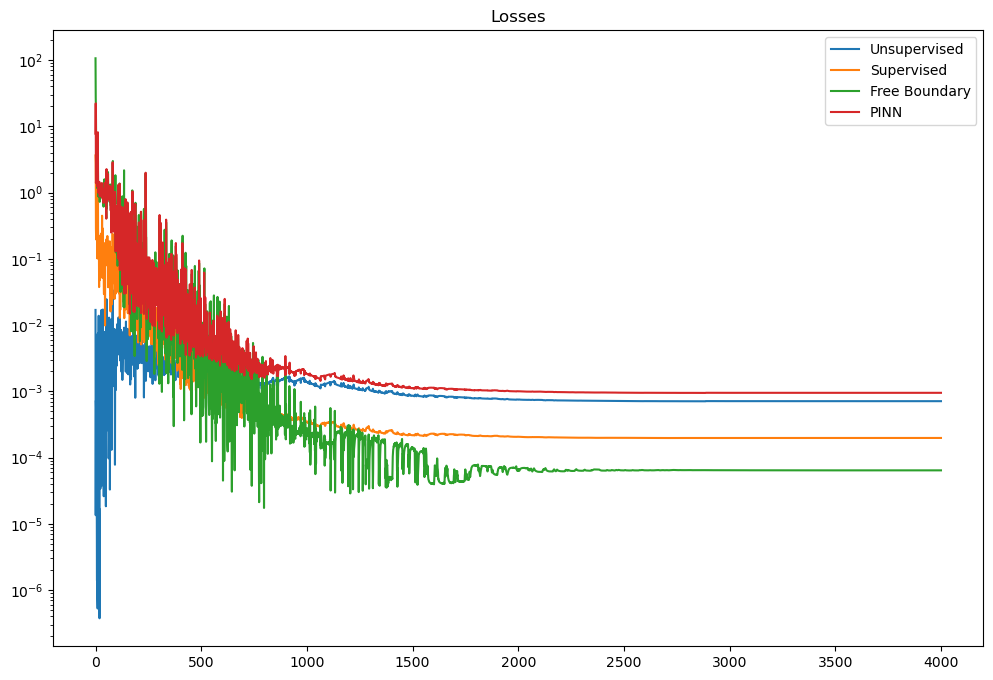

          Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          
          0.00071995     0.00021290     0.00000005     0.00000000     0.00002268     0.00003069     0.00001473     0.00006811     0.00097835     


In [7]:

from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 500, 0.9, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+1, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[1, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':my_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':20,
          'pde_weight':1, 'epochs':4000, 'verbose':50}

my_pinn = FreeBoundary_PINN(params, pde, pinn_conditions,
                            fb_conditions, lb, ub, N_f=30000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START


# 2D

### Define problem, initial and boundary conditions

In [1]:

import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback

n_dim = 2

#Fix seeds
random_seed = 2
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


F:\anaconda3\envs\PINN\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:

class Sampler_IBC():
    def __init__(self, lb, ub, cond=None, N_points=100,
                 method='sobol', grid=None, split=False, DTYPE='float64'):
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        self.sample(N_points, method, grid, split)

    def sample(self, N_points, method, grid, split):
        if method == 'uniform':
            x_ibc = np.random.uniform(0, 1, size=(N_points, self.ub.shape[0]))
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'latin':
            from pyDOE import lhs
            x_ibc = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0],N_points)
        elif method == 'sobol':
            import sobol
            x_ibc = sobol.sample(dimension=self.ub.shape[0], n_points=N_points)
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'equi':
            x_ibc = np.linspace(self.lb, self.ub, N_points)
        elif method == 'grid':
            x_ibc = np.linspace(self.lb, self.ub, N_points).T
            temp_final = list()
            for val in x_ibc[0]:
                temp_final.append( [val] )
            dim = 1
            while dim < x_ibc.shape[0]:
                temp = list()
                for t1 in range(x_ibc.shape[1]):
                    for t2 in range(len(temp_final)):
                        temp_val = temp_final[t2].copy()
                        temp_val.append( x_ibc[dim, t1] )
                        temp.append( temp_val )
                temp_final = temp
                dim += 1
            x_ibc = np.array(temp_final)
        elif method == 'grid_old':
            idx = np.random.choice(range(grid.shape[0]),N_points,replace=False)
            x_ibc = grid[idx]
        if self.cond != None:
            y_ibc = self.cond(x_ibc)
            self.y = tf.cast(tf.Variable(y_ibc, trainable=False ),
                             self.DTYPE)
        if split:
            x_ibc, t_ibc = x_ibc[:, :-1], x_ibc[:, -1:]
            self.t = tf.cast(tf.Variable(t_ibc, trainable=False ),
                             self.DTYPE)
        self.x = tf.cast(tf.Variable(x_ibc, trainable=False ),
                         self.DTYPE)


In [3]:

#Define global variables
r = 0.01
T = 3
K = 10
sigma = [[0.05, 0.01], [0.01, 0.06]]
sigma = np.array(sigma)
if np.linalg.det(sigma) != 0:
    if np.allclose(sigma, sigma.T):
        if np.all(np.linalg.eigvals(sigma) > 0):
            print('No problem with Covariance Matrix')
        else:
            print('Matrix is not positive semidefinite')
    else:
        print('Matrix is not symmetric')
else:
    print('Matrix is singular')

d = np.array([r]*n_dim) - np.array([0]*n_dim)
alphas = np.zeros((n_dim, n_dim))
for i in range(n_dim):
    alphas[i, i] = np.sum( np.dot(sigma[i], sigma[i]) )
    for j in range(i):
        alphas[i, j] = alphas[j, i] = np.sum( np.dot(sigma[i], sigma[j]) )
DTYPE = 'float32'

#Define domain boundaries
lb = np.array( ([0.]*n_dim)+[0] )
ub = np.array( ([3.*K]*n_dim)+[T] )


No problem with Covariance Matrix


In [4]:

#Problem Definition
def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0,
                            K*np.exp(-r*(T-inp_val[-1]))-\
                            np.min(inp_val[:-1])]) )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0, K - np.min(inp_val[:-1])]) )
    return np.array(res)

def s_0(inp):
    res = np.ones( (inp.shape[0], n_dim) ) * K
    return np.array(res)

#Point sampling
N_to_sample = 1500

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = Sampler_IBC(np.array( ([0.]*n_dim)+[T] ),
                           np.array( ([3.*K]*n_dim)+[T] ),
                           u_0, N_to_sample, DTYPE=DTYPE )
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
lb_dir = ([0.]*n_dim)+[0]; lb_dir[0] = 3.*K
dir_sampler = Sampler_IBC(np.array( lb_dir ),
                          np.array( ([3.*K]*n_dim)+[T] ),
                          g, N_to_sample//n_dim, DTYPE=DTYPE )
for dim in range(1, n_dim):
    lb_dir = ([0.]*n_dim)+[0]; lb_dir[dim] = 3.*K
    temp_sampler = Sampler_IBC(np.array( lb_dir ),
                              np.array( ([3.*K]*n_dim)+[T] ),
                              g, N_to_sample//n_dim, DTYPE=DTYPE )
    dir_sampler.x = tf.concat([dir_sampler.x, temp_sampler.x], axis=0)
    dir_sampler.y = tf.concat([dir_sampler.y, temp_sampler.y], axis=0)
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {neu_fb_sampler.x.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


PDE COnditions

x: (1500, 3)     y: (1500,)
x: (1500, 3)     y: (1500,)
No

Free Boundary COnditions

t: (1, 1)     y: (1, 2)
t: (1500, 1)
t: (1500, 1)


In [5]:

test_sampler = Sampler_IBC(lb, ub, cond=None, DTYPE=DTYPE,
                           N_points=1000000, method='uniform', split=True)

#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler_test = Sampler_IBC(np.array( ([0.]*n_dim)+[T] ),
                           np.array( ([3.*K]*n_dim)+[T] ),
                           u_0, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {init_sampler_test.x.shape}     y: {init_sampler_test.y.shape}' )

#Dirichlet
lb_dir = ([0.]*n_dim)+[0]; lb_dir[0] = 3.*K
dir_sampler_test = Sampler_IBC(np.array( lb_dir ),
                          np.array( ([3.*K]*n_dim)+[T] ),
                          g, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
for dim in range(1, n_dim):
    lb_dir = ([0.]*n_dim)+[0]; lb_dir[dim] = 3.*K
    temp_sampler = Sampler_IBC(np.array( lb_dir ),
                              np.array( ([3.*K]*n_dim)+[T] ),
                              g, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
    dir_sampler_test.x = tf.concat([dir_sampler_test.x, temp_sampler.x], axis=0)
    dir_sampler_test.y = tf.concat([dir_sampler_test.y, temp_sampler.y], axis=0)
print( f'x: {dir_sampler_test.x.shape}     y: {dir_sampler_test.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler_test = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE, method='uniform' )
print( f't: {init_fb_sampler_test.x.shape}     y: {init_fb_sampler_test.y.shape}' )

#Dirichlet
dir_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {dir_fb_sampler_test.x.shape}' )

#Neumann
neu_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                                  None, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
print( f't: {neu_fb_sampler_test.x.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':init_sampler_test,
                   'Dirichlet':dir_sampler_test,
                   'Neumann':None}
fb_cond_test = {'Initial':init_fb_sampler_test,
                 'Dirichlet':dir_fb_sampler_test,
                 'Neumann':neu_fb_sampler_test}


PDE COnditions

x: (1000, 3)     y: (1000,)
x: (1000, 3)     y: (1000,)
No

Free Boundary COnditions

t: (1, 1)     y: (1, 2)
t: (1000, 1)
t: (500, 1)


### PINN

In [6]:

#Define PDE
def pde(tape, vars, fun_val, fo_grads):
    second_order = 0
    first_order = 0
    zero_order = 0
    zero_order += tape.gradient(fun_val, vars[-1]) - r * fun_val
    for i, var in enumerate(vars[:-1]):
        dx_i = fo_grads[i]
        first_order += d[i] * var * dx_i
        second_order +=\
        tape.gradient(dx_i, var) * (var**2) * alphas[i, i]
        for j, var2 in enumerate(vars[:i]):
            second_order +=\
            2*( tape.gradient(dx_i, var2) * var * var2 * alphas[i, j])
    f = second_order/2 + first_order + zero_order
    del(tape)
    return f


In [7]:

import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

class FreeBoundary_PINN():

    def __init__(self, params, pde, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define pde
        self.pde = pde
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'fb_optimizer' not in target:
            self.params['fb_optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

        temp = self.params['fb_optimizer']
        if temp.lower() == 'adam':
            self.fb_opt = Adam( self.params['fb_lr'] )
        elif temp.lower() == 'rmsprop':
            self.fb_opt = RMSprop( self.params['fb_lr'] )
        else:
            raise ValueError(f"fb_Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-1], trainable=False),
                           self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -1:], trainable=False),
                           self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                    )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values[:,-1]
                            ) * K - tf.math.reduce_min(s_values, axis=1)
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_target = -tf.one_hot(
                        tf.math.argmin( s_values, axis=1),
                        depth=n_dim
                        )
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-fb_neu_target)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.fb_opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            temp = tf.reduce_sum(tf.cast(self.x_f_total < s_values,
                                         dtype=self.DTYPE),
                                axis=-1) < tf.ones(self.t_f_total.shape[0])
            x_f = self.x_f_total[ temp ]
            t_f = tf.reshape(self.t_f_total[ temp ], (-1,1) )
            variables = list()
            derivatives = list()
            for i in range(x_f.shape[1]):
                variables.append( x_f[:, i:i+1] )
            variables.append( t_f )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                for var in variables:
                    pinn_tape.watch( var )
                pinn_tape.watch(t_f)
                u_val = self.mdl(tf.concat(variables, axis=1),
                                    training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
                for i, var in enumerate(variables[:-1]):
                    derivatives.append( pinn_tape.gradient(u_val, var) )
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, variables, u_val, derivatives) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                if len(pinn_dc.shape) > 1:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      tf.expand_dims(self.ibc_cond['Dirichlet'].y,
                                                     axis=-1 ) )
                        )
                else:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      self.ibc_cond['Dirichlet'].y )
                        )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values[:,-1]
                        ) * K - tf.math.reduce_min(s_values, axis=1)
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_target = -tf.one_hot(
                    tf.math.argmin( s_values, axis=1),
                    depth=n_dim
                    )
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-fb_neu_target)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            temp = tf.reduce_sum(tf.cast(self.x_f_total < s_values,
                                         dtype=self.DTYPE),
                                axis=-1) < tf.ones(self.t_f_total.shape[0])
            x_f = self.x_f_total[ temp ]
            t_f = tf.reshape(self.t_f_total[ temp ], (-1,1) )
            variables = list()
            derivatives = list()
            for i in range(x_f.shape[1]):
                variables.append( x_f[:, i:i+1] )
            variables.append( t_f )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                for var in variables:
                    pinn_tape.watch( var )
                pinn_tape.watch(t_f)
                u_val = self.mdl(tf.concat(variables, axis=1),
                                    training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
                for i, var in enumerate(variables[:-1]):
                    derivatives.append( pinn_tape.gradient(u_val, var) )
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, variables, u_val, derivatives) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                if len(pinn_dc.shape) > 1:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      tf.expand_dims(self.ibc_cond['Dirichlet'].y,
                                                     axis=-1 ) )
                        )
                else:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      self.ibc_cond['Dirichlet'].y )
                        )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values[:,-1]
                        ) * K - tf.math.reduce_min(s_values, axis=1)
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_target = -tf.one_hot(
                    tf.math.argmin( s_values, axis=1),
                    depth=n_dim
                    )
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-fb_neu_target)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.fb_opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-test_ibc_fb_cond['Initial'].y)
                )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values[:,-1]
                    ) * K - tf.math.reduce_min(s_values, axis=1)
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=True)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_target = -tf.one_hot(
                tf.math.argmin( s_values, axis=1),
                depth=n_dim
                )
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-fb_neu_target)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t], axis=-1),
                            training=False)
        temp = tf.reduce_sum(tf.cast(test_sampler.x < s_values,
                                      dtype=self.DTYPE),
                            axis=-1) < tf.ones(test_sampler.t.shape[0])
        x_f = test_sampler.x[ temp ]
        t_f = tf.reshape(test_sampler.t[ temp ], (-1,1) )
        variables = list()
        derivatives = list()
        for i in range(x_f.shape[1]):
            variables.append( x_f[:, i:i+1] )
        variables.append( t_f )
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            for var in variables:
                pinn_tape.watch( var )
            pinn_tape.watch(t_f)
            u_val = self.mdl(tf.concat(variables, axis=1),
                                training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
            for i, var in enumerate(variables[:-1]):
                derivatives.append( pinn_tape.gradient(u_val, var) )
        unsup_loss = tf.reduce_mean(tf.square(
            self.pde(pinn_tape, variables, u_val, derivatives) ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(test_ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=True)
            if len(pinn_dc.shape) > 1:
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc -\
                                  tf.expand_dims(test_ibc_cond['Dirichlet'].y,
                                                 axis=-1 ) )
                    )
            else:
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc -\
                                  test_ibc_cond['Dirichlet'].y )
                    )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l


### Example

PINNs - Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch     Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          


1         0.00181893     14.0360889     16.5186462     0.00000000     93.4841384     28.1353664     0.48900973     122.108512     59.1809272     
101       0.04577878     0.61360120     0.41012626     0.00000000     0.33163940     0.02388267     0.46539783     0.82091993     1.55878674     
201       0.00088490     0.18385355     0.08817227     0.00000000     0.19149911     0.00221744     0.47866246     0.67237901     0.75379061     
301       0.00614011     0.14213021     0.07714815     0.00000000     0.13113255     0.06290540     0.33238527     0.52642321     0.62070918     
401       0.00079511     0.14438277     0.04600271     0.00000000     0.07236158     0.02894345     0.37835946     0.47966450     0.59848350     
501       0.00145524     0.15119317     0.06240732     0.00000000     0.00534230     0.02628427     0.29400742     0.32563

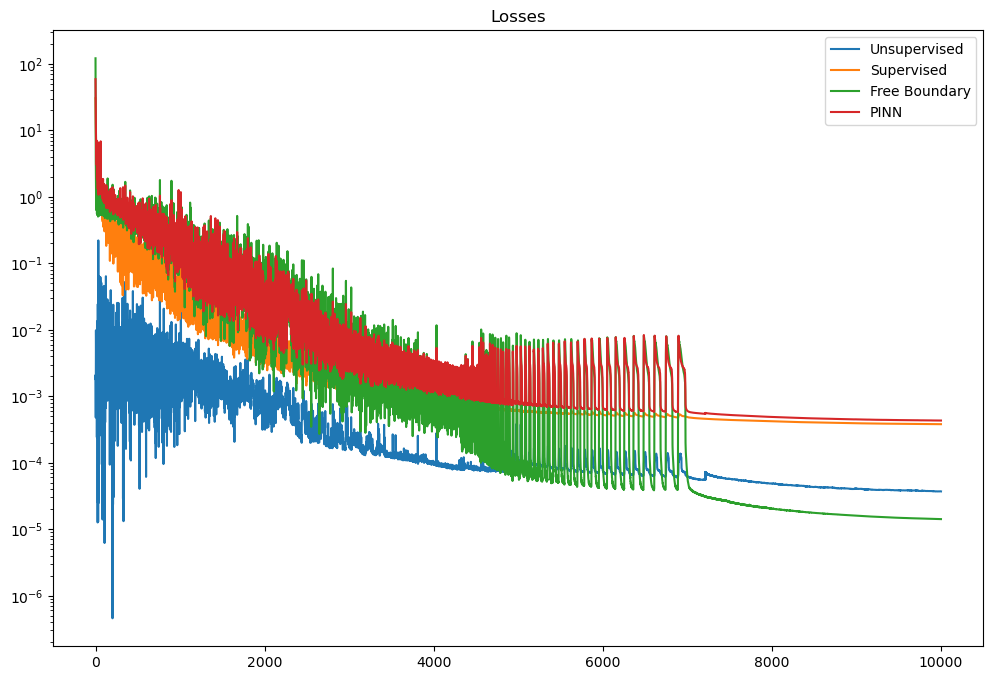

          Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          
          0.00042264     0.00097701     0.00010958     0.00000000     0.00000000     0.00000971     0.00000272     0.00001244     0.00152168     


In [8]:

from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 400, 0.9, staircase=False)
fb_lr = ex_d(1e-2, 100, 0.9, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+1, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[1, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':fb_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':4,
          'pde_weight':1, 'epochs':10000, 'verbose':100}

my_pinn = FreeBoundary_PINN(params, pde, pinn_conditions,
                            fb_conditions, lb, ub, N_f=60000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START


# 3D

### Define problem, initial and boundary conditions

In [9]:

import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback

n_dim = 3

#Fix seeds
random_seed = 2
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


In [10]:

class Sampler_IBC():
    def __init__(self, lb, ub, cond=None, N_points=100,
                 method='sobol', grid=None, split=False, DTYPE='float64'):
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        self.sample(N_points, method, grid, split)

    def sample(self, N_points, method, grid, split):
        if method == 'uniform':
            x_ibc = np.random.uniform(0, 1, size=(N_points, self.ub.shape[0]))
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'latin':
            from pyDOE import lhs
            x_ibc = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0],N_points)
        elif method == 'sobol':
            import sobol
            x_ibc = sobol.sample(dimension=self.ub.shape[0], n_points=N_points)
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'equi':
            x_ibc = np.linspace(self.lb, self.ub, N_points)
        elif method == 'grid':
            x_ibc = np.linspace(self.lb, self.ub, N_points).T
            temp_final = list()
            for val in x_ibc[0]:
                temp_final.append( [val] )
            dim = 1
            while dim < x_ibc.shape[0]:
                temp = list()
                for t1 in range(x_ibc.shape[1]):
                    for t2 in range(len(temp_final)):
                        temp_val = temp_final[t2].copy()
                        temp_val.append( x_ibc[dim, t1] )
                        temp.append( temp_val )
                temp_final = temp
                dim += 1
            x_ibc = np.array(temp_final)
        elif method == 'grid_old':
            idx = np.random.choice(range(grid.shape[0]),N_points,replace=False)
            x_ibc = grid[idx]
        if self.cond != None:
            y_ibc = self.cond(x_ibc)
            self.y = tf.cast(tf.Variable(y_ibc, trainable=False ),
                             self.DTYPE)
        if split:
            x_ibc, t_ibc = x_ibc[:, :-1], x_ibc[:, -1:]
            self.t = tf.cast(tf.Variable(t_ibc, trainable=False ),
                             self.DTYPE)
        self.x = tf.cast(tf.Variable(x_ibc, trainable=False ),
                         self.DTYPE)


In [11]:

#Define global variables
r = 0.01
T = 3
K = 10
sigma = [[0.05, 0.01, 0.1], [0.01, 0.06, -0.03], [0.1, -0.03, 0.4]]
sigma = np.array(sigma)
if np.linalg.det(sigma) != 0:
    if np.allclose(sigma, sigma.T):
        if np.all(np.linalg.eigvals(sigma) > 0):
            print('No problem with Covariance Matrix')
        else:
            print('Matrix is not positive semidefinite')
    else:
        print('Matrix is not symmetric')
else:
    print('Matrix is singular')

d = np.array([r]*n_dim) - np.array([0]*n_dim)
alphas = np.zeros((n_dim, n_dim))
for i in range(n_dim):
    alphas[i, i] = np.sum( np.dot(sigma[i], sigma[i]) )
    for j in range(i):
        alphas[i, j] = alphas[j, i] = np.sum( np.dot(sigma[i], sigma[j]) )
DTYPE = 'float32'

#Define domain boundaries
lb = np.array( ([0.]*n_dim)+[0] )
ub = np.array( ([3.*K]*n_dim)+[T] )


No problem with Covariance Matrix


In [12]:

#Problem Definition
def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0,
                            K*np.exp(-r*(T-inp_val[-1]))-\
                            np.min(inp_val[:-1])]) )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0, K - np.min(inp_val[:-1])]) )
    return np.array(res)

def s_0(inp):
    res = np.ones( (inp.shape[0], n_dim) ) * K
    return np.array(res)

#Point sampling
N_to_sample = 9000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = Sampler_IBC(np.array( ([0.]*n_dim)+[T] ),
                           np.array( ([3.*K]*n_dim)+[T] ),
                           u_0, 4000, DTYPE=DTYPE )
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
lb_dir = ([0.]*n_dim)+[0]; lb_dir[0] = 3.*K
dir_sampler = Sampler_IBC(np.array( lb_dir ),
                          np.array( ([3.*K]*n_dim)+[T] ),
                          g, N_to_sample//n_dim, DTYPE=DTYPE )
for dim in range(1, n_dim):
    lb_dir = ([0.]*n_dim)+[0]; lb_dir[dim] = 3.*K
    temp_sampler = Sampler_IBC(np.array( lb_dir ),
                              np.array( ([3.*K]*n_dim)+[T] ),
                              g, N_to_sample//n_dim, DTYPE=DTYPE )
    dir_sampler.x = tf.concat([dir_sampler.x, temp_sampler.x], axis=0)
    dir_sampler.y = tf.concat([dir_sampler.y, temp_sampler.y], axis=0)
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {neu_fb_sampler.x.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


PDE COnditions

x: (4000, 4)     y: (4000,)
x: (9000, 4)     y: (9000,)
No

Free Boundary COnditions

t: (1, 1)     y: (1, 3)
t: (9000, 1)
t: (9000, 1)


In [13]:

test_sampler = Sampler_IBC(lb, ub, cond=None, DTYPE=DTYPE,
                           N_points=1000000, method='uniform', split=True)

#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler_test = Sampler_IBC(np.array( ([0.]*n_dim)+[T] ),
                           np.array( ([3.*K]*n_dim)+[T] ),
                           u_0, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {init_sampler_test.x.shape}     y: {init_sampler_test.y.shape}' )

#Dirichlet
lb_dir = ([0.]*n_dim)+[0]; lb_dir[0] = 3.*K
dir_sampler_test = Sampler_IBC(np.array( lb_dir ),
                          np.array( ([3.*K]*n_dim)+[T] ),
                          g, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
for dim in range(1, n_dim):
    lb_dir = ([0.]*n_dim)+[0]; lb_dir[dim] = 3.*K
    temp_sampler = Sampler_IBC(np.array( lb_dir ),
                              np.array( ([3.*K]*n_dim)+[T] ),
                              g, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
    dir_sampler_test.x = tf.concat([dir_sampler_test.x, temp_sampler.x], axis=0)
    dir_sampler_test.y = tf.concat([dir_sampler_test.y, temp_sampler.y], axis=0)
print( f'x: {dir_sampler_test.x.shape}     y: {dir_sampler_test.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler_test = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE, method='uniform' )
print( f't: {init_fb_sampler_test.x.shape}     y: {init_fb_sampler_test.y.shape}' )

#Dirichlet
dir_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {dir_fb_sampler_test.x.shape}' )

#Neumann
neu_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                                  None, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
print( f't: {neu_fb_sampler_test.x.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':init_sampler_test,
                   'Dirichlet':dir_sampler_test,
                   'Neumann':None}
fb_cond_test = {'Initial':init_fb_sampler_test,
                 'Dirichlet':dir_fb_sampler_test,
                 'Neumann':neu_fb_sampler_test}


PDE COnditions

x: (1000, 4)     y: (1000,)
x: (999, 4)     y: (999,)
No

Free Boundary COnditions

t: (1, 1)     y: (1, 3)
t: (1000, 1)
t: (333, 1)


### PINN

In [14]:

#Define PDE
def pde(tape, vars, fun_val, fo_grads):
    second_order = 0
    first_order = 0
    zero_order = 0
    zero_order += tape.gradient(fun_val, vars[-1]) - r * fun_val
    for i, var in enumerate(vars[:-1]):
        dx_i = fo_grads[i]
        first_order += d[i] * var * dx_i
        second_order +=\
        tape.gradient(dx_i, var) * (var**2) * alphas[i, i]
        for j, var2 in enumerate(vars[:i]):
            second_order +=\
            2*( tape.gradient(dx_i, var2) * var * var2 * alphas[i, j])
    f = second_order/2 + first_order + zero_order
    del(tape)
    return f


In [15]:

import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

class FreeBoundary_PINN():

    def __init__(self, params, pde, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define pde
        self.pde = pde
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'fb_optimizer' not in target:
            self.params['fb_optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

        temp = self.params['fb_optimizer']
        if temp.lower() == 'adam':
            self.fb_opt = Adam( self.params['fb_lr'] )
        elif temp.lower() == 'rmsprop':
            self.fb_opt = RMSprop( self.params['fb_lr'] )
        else:
            raise ValueError(f"fb_Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-1], trainable=False),
                           self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -1:], trainable=False),
                           self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                    )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values[:,-1]
                            ) * K - tf.math.reduce_min(s_values, axis=1)
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_target = -tf.one_hot(
                        tf.math.argmin( s_values, axis=1),
                        depth=n_dim
                        )
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-fb_neu_target)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.fb_opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            temp = tf.reduce_sum(tf.cast(self.x_f_total < s_values,
                                         dtype=self.DTYPE),
                                axis=-1) < tf.ones(self.t_f_total.shape[0])
            x_f = self.x_f_total[ temp ]
            t_f = tf.reshape(self.t_f_total[ temp ], (-1,1) )
            variables = list()
            derivatives = list()
            for i in range(x_f.shape[1]):
                variables.append( x_f[:, i:i+1] )
            variables.append( t_f )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                for var in variables:
                    pinn_tape.watch( var )
                pinn_tape.watch(t_f)
                u_val = self.mdl(tf.concat(variables, axis=1),
                                    training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
                for i, var in enumerate(variables[:-1]):
                    derivatives.append( pinn_tape.gradient(u_val, var) )
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, variables, u_val, derivatives) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                if len(pinn_dc.shape) > 1:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      tf.expand_dims(self.ibc_cond['Dirichlet'].y,
                                                     axis=-1 ) )
                        )
                else:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      self.ibc_cond['Dirichlet'].y )
                        )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values[:,-1]
                        ) * K - tf.math.reduce_min(s_values, axis=1)
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_target = -tf.one_hot(
                    tf.math.argmin( s_values, axis=1),
                    depth=n_dim
                    )
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-fb_neu_target)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            temp = tf.reduce_sum(tf.cast(self.x_f_total < s_values,
                                         dtype=self.DTYPE),
                                axis=-1) < tf.ones(self.t_f_total.shape[0])
            x_f = self.x_f_total[ temp ]
            t_f = tf.reshape(self.t_f_total[ temp ], (-1,1) )
            variables = list()
            derivatives = list()
            for i in range(x_f.shape[1]):
                variables.append( x_f[:, i:i+1] )
            variables.append( t_f )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                for var in variables:
                    pinn_tape.watch( var )
                pinn_tape.watch(t_f)
                u_val = self.mdl(tf.concat(variables, axis=1),
                                    training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
                for i, var in enumerate(variables[:-1]):
                    derivatives.append( pinn_tape.gradient(u_val, var) )
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, variables, u_val, derivatives) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                if len(pinn_dc.shape) > 1:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      tf.expand_dims(self.ibc_cond['Dirichlet'].y,
                                                     axis=-1 ) )
                        )
                else:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      self.ibc_cond['Dirichlet'].y )
                        )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values[:,-1]
                        ) * K - tf.math.reduce_min(s_values, axis=1)
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_target = -tf.one_hot(
                    tf.math.argmin( s_values, axis=1),
                    depth=n_dim
                    )
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-fb_neu_target)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.fb_opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-test_ibc_fb_cond['Initial'].y)
                )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values[:,-1]
                    ) * K - tf.math.reduce_min(s_values, axis=1)
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=True)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_target = -tf.one_hot(
                tf.math.argmin( s_values, axis=1),
                depth=n_dim
                )
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-fb_neu_target)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t], axis=-1),
                            training=False)
        temp = tf.reduce_sum(tf.cast(test_sampler.x < s_values,
                                      dtype=self.DTYPE),
                            axis=-1) < tf.ones(test_sampler.t.shape[0])
        x_f = test_sampler.x[ temp ]
        t_f = tf.reshape(test_sampler.t[ temp ], (-1,1) )
        variables = list()
        derivatives = list()
        for i in range(x_f.shape[1]):
            variables.append( x_f[:, i:i+1] )
        variables.append( t_f )
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            for var in variables:
                pinn_tape.watch( var )
            pinn_tape.watch(t_f)
            u_val = self.mdl(tf.concat(variables, axis=1),
                                training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
            for i, var in enumerate(variables[:-1]):
                derivatives.append( pinn_tape.gradient(u_val, var) )
        unsup_loss = tf.reduce_mean(tf.square(
            self.pde(pinn_tape, variables, u_val, derivatives) ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(test_ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=True)
            if len(pinn_dc.shape) > 1:
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc -\
                                  tf.expand_dims(test_ibc_cond['Dirichlet'].y,
                                                 axis=-1 ) )
                    )
            else:
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc -\
                                  test_ibc_cond['Dirichlet'].y )
                    )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l


### Example

PINNs - Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch     Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          


1         0.00216231     12.7508029     14.2982368     0.00000000     99.1386718     32.3416862     0.34435033     131.824707     59.7372360     
101       0.00398006     0.97174537     0.83331066     0.00000000     0.02070968     0.00191155     0.33073264     0.35335388     2.14168024     
201       0.00136469     0.97280859     0.81005275     0.00000000     0.01368382     0.02398955     0.33217787     0.36985126     2.14039349     
301       0.00679383     0.51630854     0.54946720     0.00000000     0.10529241     0.03689799     0.32123228     0.46342271     1.43069994     
401       0.01380371     0.48393413     0.53736090     0.00000000     0.71233648     0.33528795     0.33338123     1.38100576     1.70376801     
501       0.00066707     0.42750644     0.41713798     0.00000000     0.59926158     0.45148020     0.32422533     1.37496

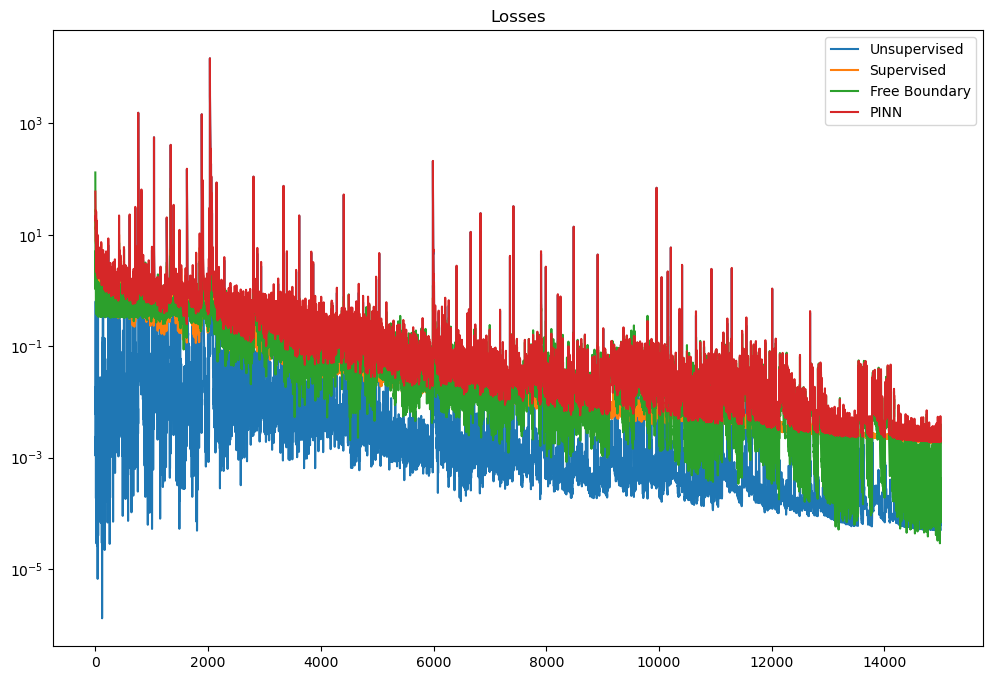

          Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          
          0.02063140     0.00866143     0.00102977     0.00000000     0.00000386     0.00002475     0.00006039     0.00008901     0.03040775     


In [16]:

from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 320, 0.975, staircase=False)
fb_lr = ex_d(1e-2, 80, 0.975, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+1, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[1, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':fb_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':4,
          'pde_weight':1, 'epochs':15000, 'verbose':100}

my_pinn = FreeBoundary_PINN(params, pde, pinn_conditions,
                            fb_conditions, lb, ub, N_f=120000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START


# 4D

### Define problem, initial and boundary conditions

In [2]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback

n_dim = 4

#Fix seeds
random_seed = 2
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

print("当前使用的分配器:", os.getenv('TF_GPU_ALLOCATOR'))

当前使用的分配器: cuda_malloc_async


In [3]:

class Sampler_IBC():
    def __init__(self, lb, ub, cond=None, N_points=100,
                 method='sobol', grid=None, split=False, DTYPE='float64'):
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        self.sample(N_points, method, grid, split)

    def sample(self, N_points, method, grid, split):
        if method == 'uniform':
            x_ibc = np.random.uniform(0, 1, size=(N_points, self.ub.shape[0]))
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'latin':
            from pyDOE import lhs
            x_ibc = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0],N_points)
        elif method == 'sobol':
            import sobol
            x_ibc = sobol.sample(dimension=self.ub.shape[0], n_points=N_points)
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'equi':
            x_ibc = np.linspace(self.lb, self.ub, N_points)
        elif method == 'grid':
            x_ibc = np.linspace(self.lb, self.ub, N_points).T
            temp_final = list()
            for val in x_ibc[0]:
                temp_final.append( [val] )
            dim = 1
            while dim < x_ibc.shape[0]:
                temp = list()
                for t1 in range(x_ibc.shape[1]):
                    for t2 in range(len(temp_final)):
                        temp_val = temp_final[t2].copy()
                        temp_val.append( x_ibc[dim, t1] )
                        temp.append( temp_val )
                temp_final = temp
                dim += 1
            x_ibc = np.array(temp_final)
        elif method == 'grid_old':
            idx = np.random.choice(range(grid.shape[0]),N_points,replace=False)
            x_ibc = grid[idx]
        if self.cond != None:
            y_ibc = self.cond(x_ibc)
            self.y = tf.cast(tf.Variable(y_ibc, trainable=False ),
                             self.DTYPE)
        if split:
            x_ibc, t_ibc = x_ibc[:, :-1], x_ibc[:, -1:]
            self.t = tf.cast(tf.Variable(t_ibc, trainable=False ),
                             self.DTYPE)
        self.x = tf.cast(tf.Variable(x_ibc, trainable=False ),
                         self.DTYPE)


In [4]:

#Define global variables
r = 0.01
T = 3
K = 10
sigma = [[0.05, 0.01, 0.1, 0], [0.01, 0.06, -0.03, 0],
         [0.1, -0.03, 0.4, 0.2], [0, 0, 0.2, 0.3]]
sigma = np.array(sigma)
if np.linalg.det(sigma) != 0:
    if np.allclose(sigma, sigma.T):
        if np.all(np.linalg.eigvals(sigma) > 0):
            print('No problem with Covariance Matrix')
        else:
            print('Matrix is not positive semidefinite')
    else:
        print('Matrix is not symmetric')
else:
    print('Matrix is singular')

d = np.array([r]*n_dim) - np.array([0]*n_dim)
alphas = np.zeros((n_dim, n_dim))
for i in range(n_dim):
    alphas[i, i] = np.sum( np.dot(sigma[i], sigma[i]) )
    for j in range(i):
        alphas[i, j] = alphas[j, i] = np.sum( np.dot(sigma[i], sigma[j]) )
DTYPE = 'float32'

#Define domain boundaries
lb = np.array( ([0.]*n_dim)+[0] )
ub = np.array( ([3.*K]*n_dim)+[T] )


No problem with Covariance Matrix


In [5]:

#Problem Definition
def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0,
                            K*np.exp(-r*(T-inp_val[-1]))-\
                            np.min(inp_val[:-1])]) )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0, K - np.min(inp_val[:-1])]) )
    return np.array(res)

def s_0(inp):
    res = np.ones( (inp.shape[0], n_dim) ) * K
    return np.array(res)

#Point sampling
N_to_sample = 12000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = Sampler_IBC(np.array( ([0.]*n_dim)+[T] ),
                           np.array( ([3.*K]*n_dim)+[T] ),
                           u_0, 12000, DTYPE=DTYPE )
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
lb_dir = ([0.]*n_dim)+[0]; lb_dir[0] = 3.*K
dir_sampler = Sampler_IBC(np.array( lb_dir ),
                          np.array( ([3.*K]*n_dim)+[T] ),
                          g, N_to_sample//n_dim, DTYPE=DTYPE )
for dim in range(1, n_dim):
    lb_dir = ([0.]*n_dim)+[0]; lb_dir[dim] = 3.*K
    temp_sampler = Sampler_IBC(np.array( lb_dir ),
                              np.array( ([3.*K]*n_dim)+[T] ),
                              g, N_to_sample//n_dim, DTYPE=DTYPE )
    dir_sampler.x = tf.concat([dir_sampler.x, temp_sampler.x], axis=0)
    dir_sampler.y = tf.concat([dir_sampler.y, temp_sampler.y], axis=0)
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {neu_fb_sampler.x.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


PDE COnditions

x: (12000, 5)     y: (12000,)
x: (12000, 5)     y: (12000,)
No

Free Boundary COnditions

t: (1, 1)     y: (1, 4)
t: (12000, 1)
t: (12000, 1)


In [6]:

test_sampler = Sampler_IBC(lb, ub, cond=None, DTYPE=DTYPE,
                           N_points=1000000, method='uniform', split=True)

#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler_test = Sampler_IBC(np.array( ([0.]*n_dim)+[T] ),
                           np.array( ([3.*K]*n_dim)+[T] ),
                           u_0, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {init_sampler_test.x.shape}     y: {init_sampler_test.y.shape}' )

#Dirichlet
lb_dir = ([0.]*n_dim)+[0]; lb_dir[0] = 3.*K
dir_sampler_test = Sampler_IBC(np.array( lb_dir ),
                          np.array( ([3.*K]*n_dim)+[T] ),
                          g, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
for dim in range(1, n_dim):
    lb_dir = ([0.]*n_dim)+[0]; lb_dir[dim] = 3.*K
    temp_sampler = Sampler_IBC(np.array( lb_dir ),
                              np.array( ([3.*K]*n_dim)+[T] ),
                              g, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
    dir_sampler_test.x = tf.concat([dir_sampler_test.x, temp_sampler.x], axis=0)
    dir_sampler_test.y = tf.concat([dir_sampler_test.y, temp_sampler.y], axis=0)
print( f'x: {dir_sampler_test.x.shape}     y: {dir_sampler_test.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler_test = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE, method='uniform' )
print( f't: {init_fb_sampler_test.x.shape}     y: {init_fb_sampler_test.y.shape}' )

#Dirichlet
dir_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {dir_fb_sampler_test.x.shape}' )

#Neumann
neu_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                                  None, sample_to_test//n_dim, DTYPE=DTYPE, method='uniform' )
print( f't: {neu_fb_sampler_test.x.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':init_sampler_test,
                   'Dirichlet':dir_sampler_test,
                   'Neumann':None}
fb_cond_test = {'Initial':init_fb_sampler_test,
                 'Dirichlet':dir_fb_sampler_test,
                 'Neumann':neu_fb_sampler_test}


PDE COnditions

x: (1000, 5)     y: (1000,)
x: (1000, 5)     y: (1000,)
No

Free Boundary COnditions

t: (1, 1)     y: (1, 4)
t: (1000, 1)
t: (250, 1)


### PINN

In [7]:

#Define PDE
def pde(tape, vars, fun_val, fo_grads):
    second_order = 0
    first_order = 0
    zero_order = 0
    zero_order += tape.gradient(fun_val, vars[-1]) - r * fun_val
    for i, var in enumerate(vars[:-1]):
        dx_i = fo_grads[i]
        first_order += d[i] * var * dx_i
        second_order +=\
        tape.gradient(dx_i, var) * (var**2) * alphas[i, i]
        for j, var2 in enumerate(vars[:i]):
            second_order +=\
            2*( tape.gradient(dx_i, var2) * var * var2 * alphas[i, j])
    f = second_order/2 + first_order + zero_order
    del(tape)
    return f


In [8]:

import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

class FreeBoundary_PINN():

    def __init__(self, params, pde, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define pde
        self.pde = pde
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'fb_optimizer' not in target:
            self.params['fb_optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

        temp = self.params['fb_optimizer']
        if temp.lower() == 'adam':
            self.fb_opt = Adam( self.params['fb_lr'] )
        elif temp.lower() == 'rmsprop':
            self.fb_opt = RMSprop( self.params['fb_lr'] )
        else:
            raise ValueError(f"fb_Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-1], trainable=False),
                           self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -1:], trainable=False),
                           self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                    )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values[:,-1]
                            ) * K - tf.math.reduce_min(s_values, axis=1)
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_target = -tf.one_hot(
                        tf.math.argmin( s_values, axis=1),
                        depth=n_dim
                        )
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-fb_neu_target)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.fb_opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            temp = tf.reduce_sum(tf.cast(self.x_f_total < s_values,
                                         dtype=self.DTYPE),
                                axis=-1) < tf.ones(self.t_f_total.shape[0])
            x_f = self.x_f_total[ temp ]
            t_f = tf.reshape(self.t_f_total[ temp ], (-1,1) )
            variables = list()
            derivatives = list()
            for i in range(x_f.shape[1]):
                variables.append( x_f[:, i:i+1] )
            variables.append( t_f )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                for var in variables:
                    pinn_tape.watch( var )
                pinn_tape.watch(t_f)
                u_val = self.mdl(tf.concat(variables, axis=1),
                                    training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
                for i, var in enumerate(variables[:-1]):
                    derivatives.append( pinn_tape.gradient(u_val, var) )
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, variables, u_val, derivatives) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                if len(pinn_dc.shape) > 1:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      tf.expand_dims(self.ibc_cond['Dirichlet'].y,
                                                     axis=-1 ) )
                        )
                else:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      self.ibc_cond['Dirichlet'].y )
                        )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values[:,-1]
                        ) * K - tf.math.reduce_min(s_values, axis=1)
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_target = -tf.one_hot(
                    tf.math.argmin( s_values, axis=1),
                    depth=n_dim
                    )
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-fb_neu_target)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            temp = tf.reduce_sum(tf.cast(self.x_f_total < s_values,
                                         dtype=self.DTYPE),
                                axis=-1) < tf.ones(self.t_f_total.shape[0])
            x_f = self.x_f_total[ temp ]
            t_f = tf.reshape(self.t_f_total[ temp ], (-1,1) )
            variables = list()
            derivatives = list()
            for i in range(x_f.shape[1]):
                variables.append( x_f[:, i:i+1] )
            variables.append( t_f )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                for var in variables:
                    pinn_tape.watch( var )
                pinn_tape.watch(t_f)
                u_val = self.mdl(tf.concat(variables, axis=1),
                                    training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
                for i, var in enumerate(variables[:-1]):
                    derivatives.append( pinn_tape.gradient(u_val, var) )
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, variables, u_val, derivatives) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                if len(pinn_dc.shape) > 1:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      tf.expand_dims(self.ibc_cond['Dirichlet'].y,
                                                     axis=-1 ) )
                        )
                else:
                    dir_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_dc -\
                                      self.ibc_cond['Dirichlet'].y )
                        )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values[:,-1]
                        ) * K - tf.math.reduce_min(s_values, axis=1)
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_target = -tf.one_hot(
                    tf.math.argmin( s_values, axis=1),
                    depth=n_dim
                    )
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-fb_neu_target)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.fb_opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-test_ibc_fb_cond['Initial'].y)
                )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values[:,-1]
                    ) * K - tf.math.reduce_min(s_values, axis=1)
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=True)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_target = -tf.one_hot(
                tf.math.argmin( s_values, axis=1),
                depth=n_dim
                )
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-fb_neu_target)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t], axis=-1),
                            training=False)
        temp = tf.reduce_sum(tf.cast(test_sampler.x < s_values,
                                      dtype=self.DTYPE),
                            axis=-1) < tf.ones(test_sampler.t.shape[0])
        x_f = test_sampler.x[ temp ]
        t_f = tf.reshape(test_sampler.t[ temp ], (-1,1) )
        variables = list()
        derivatives = list()
        for i in range(x_f.shape[1]):
            variables.append( x_f[:, i:i+1] )
        variables.append( t_f )
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            for var in variables:
                pinn_tape.watch( var )
            pinn_tape.watch(t_f)
            u_val = self.mdl(tf.concat(variables, axis=1),
                                training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
            for i, var in enumerate(variables[:-1]):
                derivatives.append( pinn_tape.gradient(u_val, var) )
        unsup_loss = tf.reduce_mean(tf.square(
            self.pde(pinn_tape, variables, u_val, derivatives) ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(test_ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=True)
            if len(pinn_dc.shape) > 1:
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc -\
                                  tf.expand_dims(test_ibc_cond['Dirichlet'].y,
                                                 axis=-1 ) )
                    )
            else:
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc -\
                                  test_ibc_cond['Dirichlet'].y )
                    )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l


### Example

PINNs - Training:   0%|          | 0/25000 [00:00<?, ?it/s]

Epoch     Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          


1         0.00212182     11.9494781     12.1659336     0.00000000     99.6774597     33.5502357     0.25983023     133.487518     57.9276008     
101       0.00755863     1.73474431     1.70499742     0.00000000     0.03353538     0.00818155     0.25000551     0.29172244     3.70548748     
201       0.02930541     1.70138669     1.74702978     0.00000000     0.90805715     0.27599051     0.27204033     1.45608806     4.02575254     
301       0.10766711     1.26599979     1.22017526     0.00000000     0.06741895     0.05172124     0.25055721     0.36969742     2.89612054     
401       0.00303481     0.89748680     0.93522983     0.00000000     0.79694896     0.00226130     0.24995365     1.04916393     2.08796644     
501       0.00624517     0.69597458     0.71379899     0.00000000     0.14697736     0.01326243     0.24784488     0.40808

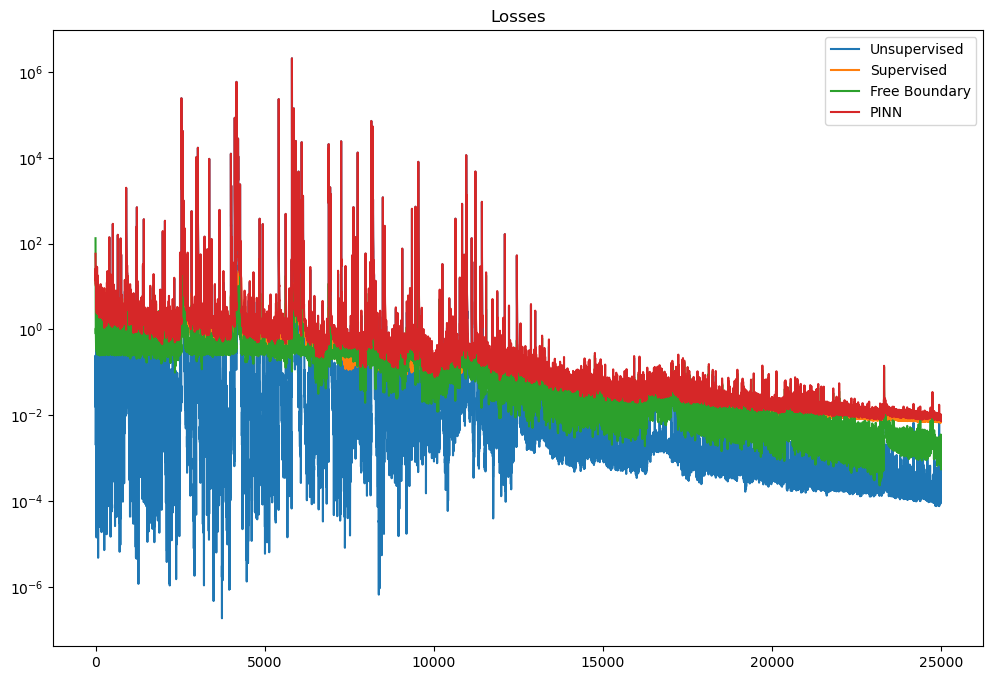

          Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          
          0.00845402     0.02223313     0.00825495     0.00000000     0.00017262     0.00008489     0.00163862     0.00189614     0.04066563     


In [9]:

from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 640, 0.975, staircase=False)
fb_lr = ex_d(1e-2, 160, 0.975, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+1, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[1, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':fb_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':4,
          'pde_weight':1, 'epochs':25000, 'verbose':100}

my_pinn = FreeBoundary_PINN(params, pde, pinn_conditions,
                            fb_conditions, lb, ub, N_f=120000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START


# 1D Semi-parametric

### Define problem, initial and boundary conditions

In [ ]:

import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback

#Define global variables
n_dim = 1
DTYPE = 'float32'

#Fix seeds
random_seed = 2
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


In [ ]:

class Sampler_IBC():
    def __init__(self, lb, ub, cond=None, N_points=100,
                 method='sobol', grid=None, this_initial_cond=False,
                 split=False, params_split=False, DTYPE='float64'):
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        self.sample(N_points, method, grid, split,
                    params_split, this_initial_cond)

    def sample(self, N_points, method, grid,
               split, params_split, this_initial_cond):
        if method == 'uniform':
            x_ibc = np.random.uniform(0, 1, size=(N_points, self.ub.shape[0]))
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'latin':
            from pyDOE import lhs
            x_ibc = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0],N_points)
        elif method == 'sobol':
            import sobol
            x_ibc = sobol.sample(dimension=self.ub.shape[0], n_points=N_points)
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'equi':
            x_ibc = np.linspace(self.lb, self.ub, N_points)
        elif method == 'grid':
            x_ibc = np.linspace(self.lb, self.ub, N_points).T
            temp_final = list()
            for val in x_ibc[0]:
                temp_final.append( [val] )
            dim = 1
            while dim < x_ibc.shape[0]:
                temp = list()
                for t1 in range(x_ibc.shape[1]):
                    for t2 in range(len(temp_final)):
                        temp_val = temp_final[t2].copy()
                        temp_val.append( x_ibc[dim, t1] )
                        temp.append( temp_val )
                temp_final = temp
                dim += 1
            x_ibc = np.array(temp_final)
        elif method == 'grid_old':
            idx = np.random.choice(range(grid.shape[0]),N_points,replace=False)
            x_ibc = grid[idx]
        #Check and, eventually, inversion of t and T
        x_ibc[:,-5] = x_ibc[:,-5] * x_ibc[:,-2]
        if this_initial_cond:
            x_ibc[:,-5] = x_ibc[:,-2]
        #Define y
        if self.cond != None:
            y_ibc = self.cond(x_ibc)
            self.y = tf.cast(tf.Variable(y_ibc, trainable=False ),
                             self.DTYPE)
        if params_split:
            x_ibc, m_p = x_ibc[:, :-4], x_ibc[:, -4:]
            self.m_p = tf.cast(tf.Variable(m_p, trainable=False ),
                             self.DTYPE)
        if split:
            x_ibc, t_ibc = x_ibc[:, :-1], x_ibc[:, -1:]
            self.t = tf.cast(tf.Variable(t_ibc, trainable=False ),
                             self.DTYPE)
        self.x = tf.cast(tf.Variable(x_ibc, trainable=False ),
                         self.DTYPE)

#Define domain boundaries
lb = np.array([0., 0., 0.01, 0.001, 3, 8])
ub = np.array([30, 1., 0.01, 0.005, 3, 12])


In [ ]:

#Problem Definition
def h_1(inp):
    res = list()
    for inp_val in inp:
        res.append( K - inp_val[0] )
    return np.array(res)

def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = np.zeros( inp.shape[0] )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0, inp_val[-1]-inp_val[0]]) )
    return np.array(res)

def s_0(inp):
    res = list()
    for inp_val in inp:
        res.append( inp_val[-1] )
    return np.array(res)

#Point sampling
N_to_sample = 9000
N_to_sample_reduced = 4500

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = Sampler_IBC(np.array([0., -1, 0.01, 0.001, 3, 8]),
                           np.array([30, -1, 0.01, 0.005, 3, 12]),
                           u_0, N_to_sample,
                           DTYPE=DTYPE, this_initial_cond=True )
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
dir_sampler = Sampler_IBC(np.array([30, 0., 0.01, 0.001, 3, 8]),
                          np.array([30, 1., 0.01, 0.005, 3, 12]),
                          g, N_to_sample, DTYPE=DTYPE )
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = Sampler_IBC(np.array([-1, 0.01, 0.001, 3, 8]),
                              np.array([-1, 0.01, 0.005, 3, 12]),
                              s_0, N_to_sample_reduced,
                              DTYPE=DTYPE, this_initial_cond=True )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = Sampler_IBC(np.array([0., 0.01, 0.001, 3, 8]),
                             np.array([1., 0.01, 0.005, 3, 12]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = Sampler_IBC(np.array([0., 0.01, 0.001, 3, 8]),
                             np.array([1., 0.01, 0.005, 3, 12]),
                             h_2, N_to_sample, DTYPE=DTYPE )
print( f't: {neu_fb_sampler.x.shape}     y: {neu_fb_sampler.y.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


In [ ]:

test_sampler = Sampler_IBC(lb, ub, cond=None, DTYPE=DTYPE,
                           N_points=10000, method='uniform', split=True, params_split=True)


#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
test_init_sampler = Sampler_IBC(np.array([0., 0, 0.01, 0.001, 3, 8]),
                           np.array([30, 0, 0.01, 0.005, 3, 12]),
                           u_0, sample_to_test, method='uniform',
                           DTYPE=DTYPE, this_initial_cond=True )
print( f'x: {test_init_sampler.x.shape}     y: {test_init_sampler.y.shape}' )

#Dirichlet
test_dir_sampler = Sampler_IBC(np.array([30, 0., 0.01, 0.001, 3, 8]),
                          np.array([30, 1., 0.01, 0.005, 3, 12]),
                          g, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {test_dir_sampler.x.shape}     y: {test_dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
test_init_fb_sampler = Sampler_IBC(np.array([0, 0.01, 0.001, 3, 8]),
                              np.array([0, 0.01, 0.005, 3, 12]),
                              s_0, sample_to_test, method='uniform',
                              DTYPE=DTYPE, this_initial_cond=True )
print(f't: {test_init_fb_sampler.x.shape}     y: {test_init_fb_sampler.y.shape}')

#Dirichlet
test_dir_fb_sampler = Sampler_IBC(np.array([0., 0.01, 0.001, 3, 8]),
                             np.array([1., 0.01, 0.005, 3, 12]),
                             None, sample_to_test, method='uniform', DTYPE=DTYPE )
print( f't: {test_dir_fb_sampler.x.shape}' )

#Neumann
test_neu_fb_sampler = Sampler_IBC(np.array([0., 0.01, 0.001, 3, 8]),
                             np.array([1., 0.01, 0.005, 3, 12]),
                             h_2, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {test_neu_fb_sampler.x.shape}     y: {test_neu_fb_sampler.y.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':test_init_sampler,
                  'Dirichlet':test_dir_sampler,
                  'Neumann':None}
fb_cond_test = {'Initial':test_init_fb_sampler,
                'Dirichlet':test_dir_fb_sampler,
                'Neumann':test_neu_fb_sampler}


### PINN

In [ ]:

import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

class FreeBoundary_PINN():
    def __init__(self, params, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
            self.m_p = coll_points[2:]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'fb_optimizer' not in target:
            self.params['fb_optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

        temp = self.params['fb_optimizer']
        if temp.lower() == 'adam':
            self.fb_opt = Adam( self.params['fb_lr'] )
        elif temp.lower() == 'rmsprop':
            self.fb_opt = RMSprop( self.params['fb_lr'] )
        else:
            raise ValueError(f"fb_Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Check and, eventually, invert t and T
        cps = np.array(cps)
        cps[:,-5] = cps[:,-5] * cps[:,-2]
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-5], trainable=False),
                           self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -5:-4], trainable=False),
                           self.DTYPE)
        self.m_p_total = tf.cast(tf.Variable(cps[:, -4:], trainable=False),
                           self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                if len(fb_init.shape) > 1:
                    fb_init_loss = tf.math.reduce_mean(
                        tf.math.square(fb_init -\
                                      tf.expand_dims(self.ibc_fb_cond['Initial'].y,
                                                     axis=-1 ) )
                        )
                else:
                    fb_init_loss = tf.math.reduce_mean(
                        tf.math.square(fb_init -\
                                      self.ibc_fb_cond['Initial'].y )
                        )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values
                            ) * self.ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.fb_opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total,
                                          self.m_p_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            m_p = self.m_p_total[ self.x_f_total[:, 0] > s_values[:, 0] ]
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.concat([x_f, t_f, m_p],
                                          axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            u_xx = pinn_tape.gradient(u_x, x_f)
            u_t = pinn_tape.gradient(u_val, t_f)
            del(pinn_tape)
            u_val = tf.cast(u_val, self.DTYPE)
            f = (m_p[:,0:1] * x_f * u_x) + u_t +\
            (m_p[:,1:2] * x_f**2 * u_xx)/2 -\
            (m_p[:,0:1] * u_val)
            unsup_loss = tf.reduce_mean(tf.square( f ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x, training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x, training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t,
                                                  self.ibc_cond['Neumann'].m_p],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            if len(fb_init.shape) > 1:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  tf.expand_dims(self.ibc_fb_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  self.ibc_fb_cond['Initial'].y )
                    )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * self.ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total,
                                          self.m_p_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            m_p = self.m_p_total[ self.x_f_total[:, 0] > s_values[:, 0] ]
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.concat([x_f, t_f, m_p],
                                          axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            u_xx = pinn_tape.gradient(u_x, x_f)
            u_t = pinn_tape.gradient(u_val, t_f)
            del(pinn_tape)
            u_val = tf.cast(u_val, self.DTYPE)
            f = (m_p[:,0:1] * x_f * u_x) + u_t +\
            (m_p[:,1:2] * x_f**2 * u_xx)/2 -\
            (m_p[:,0:1] * u_val)
            unsup_loss = tf.reduce_mean(tf.square( f ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t,
                                                  self.ibc_cond['Neumann'].m_p],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            if len(fb_init.shape) > 1:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  tf.expand_dims(self.ibc_fb_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  self.ibc_fb_cond['Initial'].y )
                    )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * self.ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.fb_opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            if len(fb_init.shape) > 1:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  tf.expand_dims(test_ibc_fb_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  test_ibc_fb_cond['Initial'].y )
                    )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values
                    ) * test_ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=False)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-test_ibc_fb_cond['Neumann'].y)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t,
                                      test_sampler.m_p], axis=-1),
                            training=False)
        x_f = tf.reshape(test_sampler.x[ test_sampler.x > s_values ],
                          (-1,1) )
        t_f = tf.reshape(test_sampler.t[ test_sampler.x > s_values ],
                          (-1,1) )
        m_p = test_sampler.m_p[ test_sampler.x[:, 0] > s_values[:, 0] ]
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            pinn_tape.watch(x_f)
            pinn_tape.watch(t_f)
            #Apply u function for unsupervised
            u_val = self.mdl(tf.concat([x_f, t_f, m_p],
                                      axis=1),
                            training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
        u_xx = pinn_tape.gradient(u_x, x_f)
        u_t = pinn_tape.gradient(u_val, t_f)
        del(pinn_tape)
        u_val = tf.cast(u_val, self.DTYPE)
        f = (m_p[:,0:1] * x_f * u_x) + u_t +\
        (m_p[:,1:2] * x_f**2 * u_xx)/2 -\
        (m_p[:,0:1] * u_val)
        unsup_loss = tf.reduce_mean(tf.square( f ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(test_ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=False)
            dir_loss = tf.math.reduce_mean(
                tf.math.square(pinn_dc-test_ibc_cond['Dirichlet'].y)
                )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t,
                                              test_ibc_cond['Neumann'].m_p],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l


### Example

In [ ]:

from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 320, 0.975, staircase=False)
fb_lr = ex_d(1e-2, 80, 0.975, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+5, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[5, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':fb_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':4,
          'pde_weight':1, 'epochs':15000, 'verbose':100}

my_pinn = FreeBoundary_PINN(params, pinn_conditions,
                            fb_conditions, lb, ub, N_f=80000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START


# 1D Parametric

### Define problem, initial and boundary conditions

In [ ]:

import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback

#Define global variables
n_dim = 1
DTYPE = 'float32'

#Fix seeds
random_seed = 2
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


In [ ]:

class Sampler_IBC():
    def __init__(self, lb, ub, cond=None, N_points=100,
                 method='sobol', grid=None, this_initial_cond=False,
                 split=False, params_split=False, DTYPE='float64'):
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        self.sample(N_points, method, grid, split,
                    params_split, this_initial_cond)

    def sample(self, N_points, method, grid,
               split, params_split, this_initial_cond):
        if method == 'uniform':
            x_ibc = np.random.uniform(0, 1, size=(N_points, self.ub.shape[0]))
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'latin':
            from pyDOE import lhs
            x_ibc = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0],N_points)
        elif method == 'sobol':
            import sobol
            x_ibc = sobol.sample(dimension=self.ub.shape[0], n_points=N_points)
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'equi':
            x_ibc = np.linspace(self.lb, self.ub, N_points)
        elif method == 'grid':
            x_ibc = np.linspace(self.lb, self.ub, N_points).T
            temp_final = list()
            for val in x_ibc[0]:
                temp_final.append( [val] )
            dim = 1
            while dim < x_ibc.shape[0]:
                temp = list()
                for t1 in range(x_ibc.shape[1]):
                    for t2 in range(len(temp_final)):
                        temp_val = temp_final[t2].copy()
                        temp_val.append( x_ibc[dim, t1] )
                        temp.append( temp_val )
                temp_final = temp
                dim += 1
            x_ibc = np.array(temp_final)
        elif method == 'grid_old':
            idx = np.random.choice(range(grid.shape[0]),N_points,replace=False)
            x_ibc = grid[idx]
        #Check and, eventually, invert t and T
        x_ibc[:,-5] = x_ibc[:,-5] * x_ibc[:,-2]
        if this_initial_cond:
            x_ibc[:,-5] = x_ibc[:,-2]
        #Derfine y
        if self.cond != None:
            y_ibc = self.cond(x_ibc)
            self.y = tf.cast(tf.Variable(y_ibc, trainable=False ),
                             self.DTYPE)
        if params_split:
            x_ibc, m_p = x_ibc[:, :-4], x_ibc[:, -4:]
            self.m_p = tf.cast(tf.Variable(m_p, trainable=False ),
                             self.DTYPE)
        if split:
            x_ibc, t_ibc = x_ibc[:, :-1], x_ibc[:, -1:]
            self.t = tf.cast(tf.Variable(t_ibc, trainable=False ),
                             self.DTYPE)
        self.x = tf.cast(tf.Variable(x_ibc, trainable=False ),
                         self.DTYPE)

#Define domain boundaries
lb = np.array([0., 0., 0.001, 0.001, 2, 8])
ub = np.array([30, 1., 0.03, 0.005, 5, 12])


In [ ]:

#Problem Definition
def h_1(inp):
    res = list()
    for inp_val in inp:
        res.append( K - inp_val[0] )
    return np.array(res)

def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = np.zeros( inp.shape[0] )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        res.append( np.max([0, inp_val[-1]-inp_val[0]]) )
    return np.array(res)

def s_0(inp):
    res = list()
    for inp_val in inp:
        res.append( inp_val[-1] )
    return np.array(res)

#Point sampling
N_to_sample = 10000
N_to_sample_reduced = 5000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = Sampler_IBC(np.array([0., -1, 0.001, 0.001, 2, 8]),
                           np.array([30, -1, 0.03, 0.005, 5, 12]),
                           u_0, N_to_sample,
                           DTYPE=DTYPE, this_initial_cond=True )
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
dir_sampler = Sampler_IBC(np.array([30, 0., 0.001, 0.001, 2, 8]),
                          np.array([30, 1., 0.03, 0.005, 5, 12]),
                          g, N_to_sample, DTYPE=DTYPE )
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = Sampler_IBC(np.array([-1, 0.001, 0.001, 2, 8]),
                              np.array([-1, 0.03, 0.005, 5, 12]),
                              s_0, N_to_sample_reduced,
                              DTYPE=DTYPE, this_initial_cond=True )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = Sampler_IBC(np.array([0., 0.001, 0.001, 2, 8]),
                             np.array([1., 0.03, 0.005, 5, 12]),
                             None, N_to_sample, DTYPE=DTYPE )
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = Sampler_IBC(np.array([0., 0.001, 0.001, 2, 8]),
                             np.array([1., 0.03, 0.005, 5, 12]),
                             h_2, N_to_sample, DTYPE=DTYPE )
print( f't: {neu_fb_sampler.x.shape}     y: {neu_fb_sampler.y.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


In [ ]:

test_sampler = Sampler_IBC(lb, ub, cond=None, DTYPE=DTYPE,
                           N_points=10000, method='uniform', split=True, params_split=True)


#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
test_init_sampler = Sampler_IBC(np.array([0., 0, 0.001, 0.001, 2, 8]),
                           np.array([30, 0, 0.03, 0.005, 5, 12]),
                           u_0, sample_to_test, method='uniform',
                           DTYPE=DTYPE, this_initial_cond=True )
print( f'x: {test_init_sampler.x.shape}     y: {test_init_sampler.y.shape}' )

#Dirichlet
test_dir_sampler = Sampler_IBC(np.array([30, 0., 0.001, 0.001, 2, 8]),
                          np.array([30, 1., 0.03, 0.005, 5, 12]),
                          g, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {test_dir_sampler.x.shape}     y: {test_dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
test_init_fb_sampler = Sampler_IBC(np.array([0, 0.001, 0.001, 2, 8]),
                              np.array([0, 0.03, 0.005, 5, 12]),
                              s_0, sample_to_test, method='uniform',
                              DTYPE=DTYPE, this_initial_cond=True )
print( f't: {test_init_fb_sampler.x.shape}     y: {test_init_fb_sampler.y.shape}' )

#Dirichlet
test_dir_fb_sampler = Sampler_IBC(np.array([0., 0.001, 0.001, 2, 8]),
                             np.array([1., 0.03, 0.005, 5, 12]),
                             None, sample_to_test, method='uniform', DTYPE=DTYPE )
print( f't: {test_dir_fb_sampler.x.shape}' )

#Neumann
test_neu_fb_sampler = Sampler_IBC(np.array([0., 0.001, 0.001, 2, 8]),
                             np.array([1., 0.03, 0.005, 5, 12]),
                             h_2, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {test_neu_fb_sampler.x.shape}     y: {test_neu_fb_sampler.y.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':test_init_sampler,
                  'Dirichlet':test_dir_sampler,
                  'Neumann':None}
fb_cond_test = {'Initial':test_init_fb_sampler,
                'Dirichlet':test_dir_fb_sampler,
                'Neumann':test_neu_fb_sampler}


### PINN

In [ ]:

import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

class FreeBoundary_PINN():
    def __init__(self, params, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
            self.m_p = coll_points[2:]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'fb_optimizer' not in target:
            self.params['fb_optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

        temp = self.params['fb_optimizer']
        if temp.lower() == 'adam':
            self.fb_opt = Adam( self.params['fb_lr'] )
        elif temp.lower() == 'rmsprop':
            self.fb_opt = RMSprop( self.params['fb_lr'] )
        else:
            raise ValueError(f"fb_Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Check and, eventually, invert t and T
        cps = np.array(cps)
        cps[:,-5] = cps[:,-5] * cps[:,-2]
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-5], trainable=False),
                           self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -5:-4], trainable=False),
                           self.DTYPE)
        self.m_p_total = tf.cast(tf.Variable(cps[:, -4:], trainable=False),
                           self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                if len(fb_init.shape) > 1:
                    fb_init_loss = tf.math.reduce_mean(
                        tf.math.square(fb_init -\
                                      tf.expand_dims(self.ibc_fb_cond['Initial'].y,
                                                     axis=-1 ) )
                        )
                else:
                    fb_init_loss = tf.math.reduce_mean(
                        tf.math.square(fb_init -\
                                      self.ibc_fb_cond['Initial'].y )
                        )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values
                            ) * self.ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.fb_opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total,
                                          self.m_p_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            m_p = self.m_p_total[ self.x_f_total[:, 0] > s_values[:, 0] ]
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.concat([x_f, t_f, m_p],
                                          axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            u_xx = pinn_tape.gradient(u_x, x_f)
            u_t = pinn_tape.gradient(u_val, t_f)
            del(pinn_tape)
            u_val = tf.cast(u_val, self.DTYPE)
            f = (m_p[:,0:1] * x_f * u_x) + u_t +\
            (m_p[:,1:2] * x_f**2 * u_xx)/2 -\
            (m_p[:,0:1] * u_val)
            unsup_loss = tf.reduce_mean(tf.square( f ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x, training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x, training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t,
                                                  self.ibc_cond['Neumann'].m_p],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            if len(fb_init.shape) > 1:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  tf.expand_dims(self.ibc_fb_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  self.ibc_fb_cond['Initial'].y )
                    )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * self.ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total,
                                          self.m_p_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            m_p = self.m_p_total[ self.x_f_total[:, 0] > s_values[:, 0] ]
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.concat([x_f, t_f, m_p],
                                          axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            u_xx = pinn_tape.gradient(u_x, x_f)
            u_t = pinn_tape.gradient(u_val, t_f)
            del(pinn_tape)
            u_val = tf.cast(u_val, self.DTYPE)
            f = (m_p[:,0:1] * x_f * u_x) + u_t +\
            (m_p[:,1:2] * x_f**2 * u_xx)/2 -\
            (m_p[:,0:1] * u_val)
            unsup_loss = tf.reduce_mean(tf.square( f ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t,
                                                  self.ibc_cond['Neumann'].m_p],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            if len(fb_init.shape) > 1:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  tf.expand_dims(self.ibc_fb_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  self.ibc_fb_cond['Initial'].y )
                    )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * self.ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.fb_opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']), desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            if len(fb_init.shape) > 1:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  tf.expand_dims(test_ibc_fb_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init -\
                                  test_ibc_fb_cond['Initial'].y )
                    )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values
                    ) * test_ibc_fb_cond['Dirichlet'].x[:,-1] - s_values
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=False)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-test_ibc_fb_cond['Neumann'].y)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t,
                                      test_sampler.m_p], axis=-1),
                            training=False)
        x_f = tf.reshape(test_sampler.x[ test_sampler.x > s_values ],
                          (-1,1) )
        t_f = tf.reshape(test_sampler.t[ test_sampler.x > s_values ],
                          (-1,1) )
        m_p = test_sampler.m_p[ test_sampler.x[:, 0] > s_values[:, 0] ]
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            pinn_tape.watch(x_f)
            pinn_tape.watch(t_f)
            #Apply u function for unsupervised
            u_val = self.mdl(tf.concat([x_f, t_f, m_p],
                                      axis=1),
                            training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
        u_xx = pinn_tape.gradient(u_x, x_f)
        u_t = pinn_tape.gradient(u_val, t_f)
        del(pinn_tape)
        u_val = tf.cast(u_val, self.DTYPE)
        f = (m_p[:,0:1] * x_f * u_x) + u_t +\
        (m_p[:,1:2] * x_f**2 * u_xx)/2 -\
        (m_p[:,0:1] * u_val)
        unsup_loss = tf.reduce_mean(tf.square( f ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(test_ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=False)
            dir_loss = tf.math.reduce_mean(
                tf.math.square(pinn_dc-test_ibc_cond['Dirichlet'].y)
                )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t,
                                              test_ibc_cond['Neumann'].m_p],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l


### Example

In [ ]:

from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 320, 0.975, staircase=False)
fb_lr = ex_d(1e-2, 80, 0.975, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+5, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[5, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':fb_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':4,
          'pde_weight':1, 'epochs':15000, 'verbose':100}

my_pinn = FreeBoundary_PINN(params, pinn_conditions,
                            fb_conditions, lb, ub, N_f=100000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START
